# Higher-performance computing

There are various ways to speed up the execution of code in a Jupyter notebook.  
We will start scratching the surface by looking at

- Numba
- Fortran magic
- Cython

Other ways to increase performance include

- **Numexpr** - a package that speeds up complex array operations (sometimes slow in numpy due to creation of many temporary arrays)
- wrapping C libraries with **ctypes**
- **CFFI** (C Foreign Function Interface for Python)
- **SWIG** (Simplified Wrapper and Interface Generator)
- create a new magic command which compiles C/C++/Fortran code, runs it and returns result!

## Numba

Numpy offers fast vector computations of arrays, but some algorithms can't be vectorized and require explicit loops.  
However, Python loops are slow. `Numba` can speed up Python through a *just-in-time* (JIT) compiler, compiling Python code directly to machine code. 

### Random walk

First without Numba

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
def step():
    return 1. if random.random() > .5 else -1.

In [3]:
def walk(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

In [4]:
n = 100000
x = walk(n)

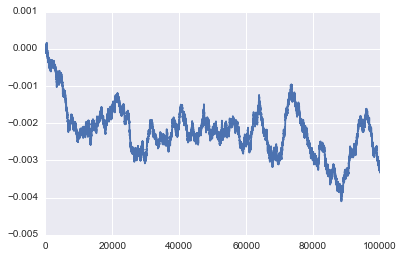

In [5]:
plt.plot(x)

In [6]:
%%timeit
walk(n)

10 loops, best of 3: 106 ms per loop


### <font color="blue"> Demo, *just-in-time* compilation

We import the Numba package, and then add the decorator `@jit` immediately before the function definition

The `nopython=True` argument activates nopython mode, which means that the code is translated directly to machine code, bypassing the CPython interpreter. The nopython mode is faster than python mode, but is more limited and for example lists and dictionaries are not supported. For optimal performance, try to stick with nopython!  

## Mixing in Fortran and C 

* One can compile external functions in Fortran or C, and write python wrappers...
* but it's even simpler to directly use Fortran or Cython, hiding away the wrapping! 

In [69]:
#!pip install cython fortran-magic

### Fortran

The %%fortran cell magic allows us to write Fortran code into a cell, which gets compiled and imported using `f2py`.


In [70]:
%%fortran?

In [71]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [72]:
%%fortran -vvv
# -vvv for verbose output for what is happening under the hood
# One can also give compiler flags, e.g. for OpenMP parallellization
#%%fortran -vvv --f90flags='-fopenmp' --extra='-lgomp' # for OpenMP support
subroutine my_function(x, y, z)
    real, intent(in) :: x(:), y(:)
    real, intent(out) :: z(size(x))
    ! using vector operations  
    z(:) = sin(x(:) + y(:))
end subroutine

Running...
   /Users/ktw/anaconda2/bin/python -m numpy.f2py -m _fortran_magic_67c6d4756b44a5d5ce607e55199e220e -c /Users/ktw/.ipython/fortran/_fortran_magic_67c6d4756b44a5d5ce607e55199e220e.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "_fortran_magic_67c6d4756b44a5d5ce607e55199e220e" sources
f2py options: []
f2py:> /var/folders/2y/083kpwjs5zlc_3db05ll22180000gn/T/tmp9PZPHN/src.macosx-10.6-x86_64-2.7/_fortran_magic_67c6d4756b44a5d5ce607e55199e220emodule.c
creating /var/folders/2y/083kpwjs5zlc_3db05ll22180000gn/T/tmp9PZPHN/src.macosx-10.6-x86_64-2.7
Reading fortran codes...
	Reading file '/Users/ktw/.ipython/fortran/_fortran_magic_67c6d4756b44a5d5ce607e55199e220e.f90' (format:free)
Post-processing...
	Block: _fortran_magic_67c6d4756b44a5d5ce607e55199e220e
			Block: m

In [73]:
import numpy as np
x = np.random.normal(size=100)
y = np.random.normal(size=100)
z = my_function(x, y)

### Cython

Cython is a superset of Python which supports calling C functions and declaring C types on variables and class attributes.
Cython allows you to
- wrap C/C++ libraries into Python
- optimize Python code by statically compiling with C


In [74]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### <font color="blue"> Demo: the Mandelbrot fractal

Initialize:

In [75]:
size = 200
iterations = 100

#### Pure python

In [76]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [77]:
%%timeit -n1 -r1 
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1 loop, best of 1: 2.35 s per loop


#### First cython attempt

First just add the cython magic

#### Second attempt

Now add type information, use *memory views* for NumPy arrays, and replace `np.dot()`

### <font color="red"> *Exercise: calculate primes*

- Take the following Python code which returns prime numbers
- Run it for `kmax=100` and time it
- Add the most simple cythonization
- Run again and time, compare to pure Python
- Cythonize it properly! (Hint: replace `p=[]` also)
- Try just-in-time compilation using `Numba` and compare to `Cython`

In [78]:
def primes(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result